In [1]:
import cobra
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load PAMpy modules

In [2]:
# load PAMpy modules
sys.path.append('../Package/')
from PAModel import PAModel
from EnzymeSectors import ActiveEnzymeSector, UnusedEnzymeSector, TransEnzymeSector
from PAMValidator import PAMValidator

# Load E. coli core model

In [3]:
# load the model
model = cobra.io.load_json_model('../models/e_coli_core.json')
# test the model
sol_t = model.optimize()
print(model.summary())

Objective
1.0 BIOMASS_Ecoli_core_w_GAM = 0.87392150696843

Uptake
------
Metabolite    Reaction  Flux  C-Number  C-Flux
  glc__D_e EX_glc__D_e    10         6 100.00%
     nh4_e    EX_nh4_e 4.765         0   0.00%
      o2_e     EX_o2_e  21.8         0   0.00%
      pi_e     EX_pi_e 3.215         0   0.00%

Secretion
---------
Metabolite Reaction   Flux  C-Number  C-Flux
     co2_e EX_co2_e -22.81         1 100.00%
     h2o_e EX_h2o_e -29.18         0   0.00%
       h_e   EX_h_e -17.53         0   0.00%



# Build E. coli core PAM
## Create Protein Sectors
### Active Enzymes

In [4]:
# load enzyme database from genome-scale E. coli PAM
enzyme_db = pd.read_excel('../data/proteinAllocationModel_iML1515_EnzymaticData_py.xls',
                          sheet_name='ActiveEnzymes', index_col=0)

# correct reaction IDS
for idx in enzyme_db.index.to_list():
    # transprt reactions<
    
    if 'pp' in idx:
        idx_new = idx.replace('pp', '')
        if idx_new not in enzyme_db.index:
            enzyme_db.rename(index={idx: idx_new}, inplace=True)
    if 'ex' in idx:
        idx_new = idx.replace('ex', '')
        if idx_new not in enzyme_db.index:
            enzyme_db.rename(index={idx: idx_new}, inplace=True)    

enzyme_db

,rxnName,rxnEquat,EC_nmbr,molMass,kcat
rxnID,,,,,
ALATA_D2,D-alanine transaminase,pydx5p_c + ala__D_c -> pyam5p_c + pyr_c,"2.1.2.1, 4.1.2.48",40904.4850,6.862500e+00
SHCHD2,Sirohydrochlorin dehydrogenase (NAD),nad_c + dscl_c -> h_c + scl_c + nadh_c,1.3.1.76,49950.0000,4.500000e-01
CPPPGO,Coproporphyrinogen oxidase (O2 required),2 h_c + o2_c + cpppg3_c -> 2 h2o_c + pppg9_c ...,1.3.3.3,34321.4900,3.000000e-03
GTHOr_f,Glutathione oxidoreductase,h_c + nadph_c + gthox_c -> 2 gthrd_c + nadp_c,1.8.1.7,48771.0500,7.333000e+02
DHORD5,Dihydroorotic acid (menaquinone-8),dhor__S_c + mqn8_c -> orot_c + mql8_c,1.3.5.2,36773.4600,8.200000e+01
...,...,...,...,...,...
AI2t_b,"Ai2 transport, outer membrane",mththf_p -> mththf_e,NaN,39959.4825,2.200000e+01
RHMND_b,L-rhamnonate dehydratase,lkdr_c + h2o_c -> rhmn_c,4.2.1.90,44225.1000,2.000000e-02
ASPtpp_b,L-aspartate uptake via facillitated diffusion,asp__L_c -> asp__L_p,NaN,59427.5800,1.000000e+08


In [5]:
# create enzyme objects for each gene-associated reaction
kcats = {}
rxn2ec = {}
molmass = {}
for rxn in model.reactions:
    if rxn.genes:
        # correct transport reactions
        if 't' in rxn.id:
            rxn.id = rxn.id
        # are enzyme information in the PAM database?
        rev = 0 # denotes reversibility
        if rxn.lower_bound >= 0:
            # irreversible reaction (forward direction)
            rev = 0
            rxn_id = rxn.id # save reaction ID for retrieveing molar masses/enzyme information later
            if rxn.id in enzyme_db.index:
                kcats[rxn.id] = {'f': enzyme_db.loc[rxn.id, 'kcat']}
        elif rxn.upper_bound <= 0:
            # irreversible reaction (reverse direction)
            rev = 1
            rxn_id = rxn.id + '_b'
            if rxn_id in enzyme_db.index:
                kcats[rxn.id] = {'b': enzyme_db.loc[rxn_id, 'kcat']}
        else:
            rev = 2
            # reversible reaction
            rxn_id_f = rxn.id + '_f'
            rxn_id_b = rxn.id + '_b'
            if rxn_id_f in enzyme_db.index and rxn_id_b in enzyme_db.index:
                rxn_id = rxn_id_f # save reaction ID for retrieveing molar masses/enzyme information later
                kcats[rxn.id] = {'f': enzyme_db.loc[rxn_id_f, 'kcat'],
                                 'b': enzyme_db.loc[rxn_id_b, 'kcat']}

            else:
                # try if only forward reaction is in database
                rxn_id = rxn.id # save reaction ID for retrieveing molar masses/enzyme information later
                kcats[rxn.id] = {'f': enzyme_db.loc[rxn.id, 'kcat'],
                                 'b': enzyme_db.loc[rxn.id, 'kcat']/2} # deduce backwards kcat from forward value

        # where enzyme information found?
        if rxn.id in kcats.keys():
            # save molmass
            molmass[rxn.id] = enzyme_db.loc[rxn_id, 'molMass']
            #save enzyme information
            # is enzyme information NaN?
            if pd.isna(enzyme_db.loc[rxn_id, 'EC_nmbr']):
                rxn2ec[rxn.id] = ''
            else:
                rxn2ec[rxn.id] = enzyme_db.loc[rxn_id, 'EC_nmbr']
            
            
        else:
            # no enzyme information found
            print('No enzyme information found for reaction: ' + rxn.id)
            # Create generic Enzyme with mean molar masses and kcat
            if rev == 0:
                kcats[rxn.id] = {'f': 22}
            elif rev == 1: 
                kcats[rxn.id] = {'b': 22}
            else:
                kcats[rxn.id] = {'f': 22, 'b': 22}
                
            molmass[rxn.id] = 3.947778784340140e04

rxn2protein = {}
for rxn, ec in rxn2ec.items():
    ec_dict = {**kcats[rxn], **{'molmass': molmass[rxn]}}
    #add enzyme to enzymes related to reaction if these are already stored
    if rxn in rxn2protein.keys():
        rxn2protein[rxn] = {**rxn2protein[rxn], **{ec:ec_dict}}
    #if not create new reaction entry
    else:
        rxn2protein[rxn] = {ec:ec_dict}
          


# create active enzymes sector
active_enzyme_sector = ActiveEnzymeSector(rxn2protein=rxn2protein)

No enzyme information found for reaction: FRD7


### Translational Protein Sector

In [6]:
# # translational protein sector parameter (growth rate dependent)
# id_list_tps = ['BIOMASS_Ecoli_core_w_GAM']
# tps_0 = [0.04992] # g/gDW
# tps_mu = [0.0368] # g h/gDW
# molmass_tps = [405903.94] # g/mol

# translational protein sector parameter (substrate dependent)
id_list_tps = ['EX_glc__D_e']
tps_0 = [0.04992] # g/gDW
tps_mu = [-0.002944] # g h/gDW -> transformed to match glucose uptake variable
molmass_tps = [405903.94] # g/mol

# translational protein sector
translational_enzyme_sector = TransEnzymeSector(
    id_list=id_list_tps,
    tps_0=tps_0,
    tps_mu=tps_mu,
    mol_mass  = molmass_tps,
)

### Total Protein Constraint

In [7]:
# total protein constraint (cf. analyze_proteome.ipynb)
p_tot = 0.140 # g/gDW -> Standard 0.14 g/gDW 

## Build PAM


In [8]:
# set up PAM
pa_model = PAModel(
    id_or_model=model,
    p_tot=p_tot,
    sensitivity = False,
    translational_sector=translational_enzyme_sector,
    active_sector=active_enzyme_sector,
)


Setting up the proteome allocation model e_coli_core

Add total condition-dependent protein constraint
	Total protein concentration: 0.14 g/gDW

Add active protein sector

Add the following protein sector: TranslationalProteinSector

Done with setting up the proteome allocation model e_coli_core



# Test PAM model
## Load phenotype data

In [9]:
# load phenotype data from excel file
pt_data = pd.read_excel('../data/Ecoli_phenotypes_py_rev.xls', sheet_name='Yields', index_col=None)
pt_data

# extract reaction specific data 
rxn_to_pt = {}
rxn_transform = {
    'EX_ac_e': 'Acetate_OUT',
    'EX_co2_e': 'CO2_OUT',
    'EX_o2_e': 'O2_IN',
    'BIOMASS_Ecoli_core_w_GAM': 'mu'
}
for rxn_id, pt_id in rxn_transform.items():
    rxn_to_pt[rxn_id] = pt_data[['Glucose_IN', pt_id]].dropna().rename(columns={pt_id: rxn_id})


## Simulate PAM

In [10]:
with pa_model:
    # change glucose uptake rate
    pa_model.reactions.EX_glc__D_e.lower_bound = -6.0
    # solve the model
    sol_pam = pa_model.optimize()
    # print(pa_model.summary())
    # with pd.option_context('display.max_rows', None):
    #     print(sol_pam.fluxes)
pa_model.optimize()

AttributeError: 'PAModel' object has no attribute 'solution'

## Change kcat values

In [ ]:
# # citrate synthase
# e = pa_model.catalytic_events.get_by_id('CE_CS').enzymes[0]
# pa_model.catalytic_events.get_by_id('CE_CS').change_kcat_values({e: {'f': 5}})

## Scan glucose uptake rates

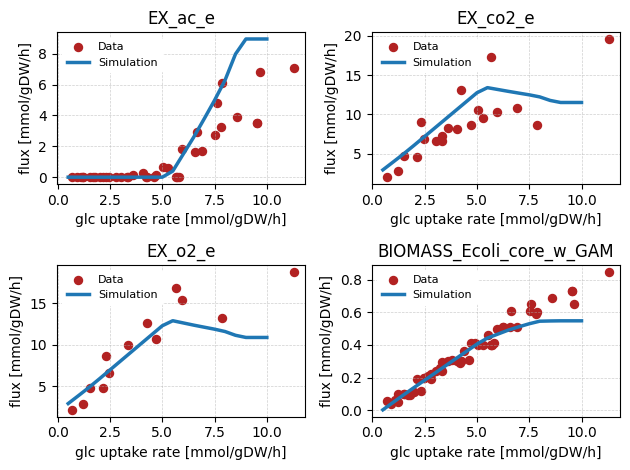

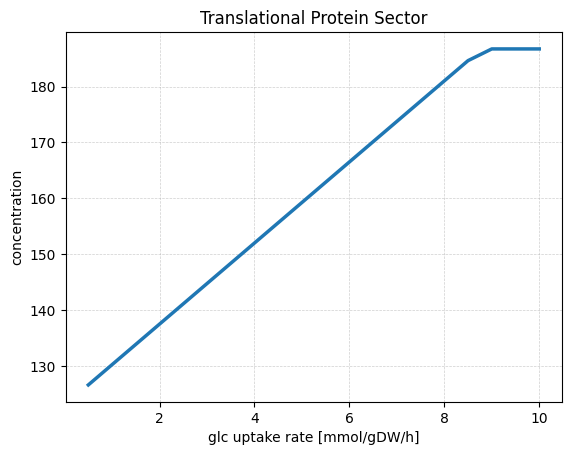

In [11]:
glc_uptake_rates = np.linspace(0.5, 10, 20)
fluxes = []
concentrations = []
for glc in glc_uptake_rates:
    with pa_model:
        # change glucose uptake rate
        pa_model.reactions.EX_glc__D_e.lower_bound = -glc
        # disable pyruvate formate lyase (inhibited by oxygen)
        pa_model.reactions.PFL.upper_bound = 0
        # solve the model
        sol_pam = pa_model.optimize()
        # save data
        fluxes.append(sol_pam.fluxes) # flux distributions
        concentrations.append({
            'R_TranslationalProteinSector': pa_model.variables['R_TranslationalProteinSector'].primal,
            })

# plot flux changes with glucose uptake
rxn_id = ['EX_ac_e', 'EX_co2_e', 'EX_o2_e', 'BIOMASS_Ecoli_core_w_GAM',
          'R_TranslationalProteinSector']
fig, axs = plt.subplots(2,2, dpi=100)
for r, ax in zip(rxn_id, axs.flatten()):
    # plot data
    if r in rxn_to_pt.keys():
        ax.scatter(rxn_to_pt[r]['Glucose_IN'], rxn_to_pt[r][r],
                   color='firebrick', marker='o', s=30, linewidths=1.3,
                   facecolors=None, zorder=0,
                   label='Data')
        
    # plot simulation
    ax.plot(glc_uptake_rates, [abs(f[r]) for f in fluxes],
            label='Simulation', linewidth=2.5,
            zorder=5)
   
    
    # options
    ax.set_xlabel('glc uptake rate [mmol/gDW/h]')
    ax.set_ylabel('flux [mmol/gDW/h]')
    ax.set_title(r)
    # set grid
    ax.grid(True, axis='both', linestyle='--', linewidth=0.5, alpha=0.6   )
    ax.set_axisbelow(True)
    # show legend
    ax.legend(fontsize=8, edgecolor='white', facecolor='white', framealpha=1)

plt.tight_layout()


# plot concentration changes with glucose uptake
fig, ax = plt.subplots(1,1, dpi=100)
# plot simulation
ax.plot(glc_uptake_rates, [abs(c['R_TranslationalProteinSector']) for c in concentrations],
        linewidth=2.5, zorder=5)
ax.set_title('Translational Protein Sector')
ax.set_xlabel('glc uptake rate [mmol/gDW/h]')
ax.set_ylabel('concentration')
# set grid
ax.grid(True, axis='both', linestyle='--', linewidth=0.5, alpha=0.6   )
ax.set_axisbelow(True)